/Users/ayush/Desktop/snn-working-memory-edge-ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/6p/x54f4_t51z75lb262gn_9w940000gn/T/ipykernel_54548/3422919889.py:16: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


130864128it [00:07, 17355955.05it/s]                               


Extracting ../data/SHD/shd_train.h5.zip to ../data/SHD


38141952it [00:02, 13748881.09it/s]                              


Extracting ../data/SHD/shd_test.h5.zip to ../data/SHD
Epoch 1 | Loss: 13.099601745605469 | Training Accuracy: 0.03515625
Epoch 11 | Loss: 2.5529427528381348 | Training Accuracy: 0.38671875
Epoch 21 | Loss: 2.208735227584839 | Training Accuracy: 0.63671875
Epoch 31 | Loss: 2.0663390159606934 | Training Accuracy: 0.75390625
Epoch 41 | Loss: 2.056398868560791 | Training Accuracy: 0.71875
Epoch 51 | Loss: 1.9875586032867432 | Training Accuracy: 0.7890625
Epoch 61 | Loss: 1.9492080211639404 | Training Accuracy: 0.80078125
Epoch 71 | Loss: 1.9508821964263916 | Training Accuracy: 0.82421875
Epoch 81 | Loss: 1.9237799644470215 | Training Accuracy: 0.828125
Epoch 91 | Loss: 1.8885204792022705 | Training Accuracy: 0.8515625
Test Accuracy: 69.43%


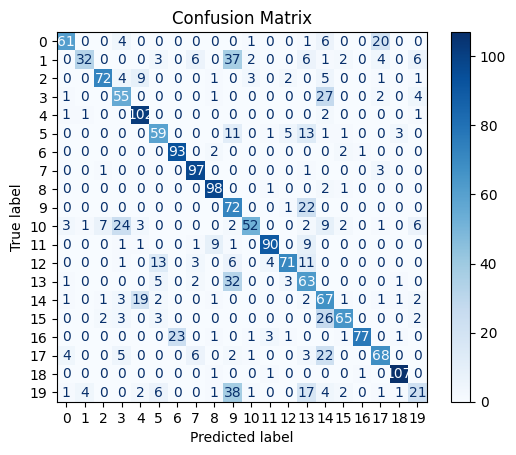

In [1]:
import torch
import snntorch
import tonic
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from tonic import datasets, transforms
from collections import namedtuple
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt


device = torch.device("mps" if torch.cuda.is_available() else "cpu")

spike_grad = surrogate.atan(alpha=2.4)


SAMPLE_T = 128  # Time steps per sample
SHD_TIMESTEP = 1e-6  # Time step of SHD dataset
SHD_CHANNELS = 700  # Number of input channels in the SHD dataset
NET_CHANNELS = 128  # Number of input channels in the network
NET_DT = 1 / SAMPLE_T  # Time step for network
BATCH_SIZE = 256  # Batch size
NUM_EPOCHS = 100  # Increased number of epochs
NUM_HIDDEN = 128  # Increased number of hidden units

# Set the input and output shapes
OBS_SHAPE = (NET_CHANNELS,)
ACT_SHAPE = (20,)

from datetime import datetime

# Set up TensorBoard  
run_name = f"SNN_4_lif_hidden_{NUM_HIDDEN}_epochs_{NUM_EPOCHS}"
writer = SummaryWriter(log_dir=f"runs/{run_name}")

class _SHD2Raster:
    """Helper for rasterizing SHD samples into frames."""
    def __init__(self, encoding_dim, sample_T=100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T
        
    def __call__(self, events):
        tensor = np.zeros((events["t"].max() + 1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        tensor = tensor[:self.sample_T, :]
        tensor = np.minimum(tensor, 1)
        return tensor


transform = transforms.Compose([
    transforms.Downsample(time_factor=SHD_TIMESTEP / NET_DT, spatial_factor=NET_CHANNELS / SHD_CHANNELS),
    _SHD2Raster(NET_CHANNELS, sample_T=SAMPLE_T)
])

train_dataset = datasets.SHD("../data", train=True, transform=transform)
test_dataset = datasets.SHD("../data", train=False, transform=transform)


def shuffle(dataset):
    x, y = dataset
    cutoff = y.shape[0] % BATCH_SIZE
    indices = torch.randperm(y.shape[0])[:-cutoff]
    x, y = x[indices], y[indices]
    x = torch.reshape(x, (-1, BATCH_SIZE) + x.shape[1:])
    y = torch.reshape(y, (-1, BATCH_SIZE))
    return namedtuple("State", "obs labels")(x, y)

train_dl = iter(DataLoader(train_dataset, batch_size=len(train_dataset),
                           collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
x_train, y_train = next(train_dl)
x_train, y_train = x_train.to(torch.uint8), y_train.to(torch.uint8)
x_train, y_train = x_train.to(device), y_train.to(device)

test_dl = iter(DataLoader(test_dataset, batch_size=len(test_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
x_test, y_test = next(test_dl)
x_test, y_test = x_test.to(torch.uint8), y_test.to(torch.uint8)
x_test, y_test = x_test.to(device), y_test.to(device)
x_test, y_test = shuffle((x_test, y_test))


class SNNModel(torch.nn.Module):
    def __init__(self, num_hidden=NUM_HIDDEN, output_size=20):
        super(SNNModel, self).__init__()
        
        self.fc1 = torch.nn.Linear(NET_CHANNELS, num_hidden)
        self.lif1 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True, spike_grad=spike_grad)
        
        self.fc2 = torch.nn.Linear(num_hidden, num_hidden)
        self.lif2 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True, spike_grad=spike_grad)
        
        self.fc3 = torch.nn.Linear(num_hidden, num_hidden)
        self.lif3 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True, spike_grad=spike_grad)
        
        self.fc4 = torch.nn.Linear(num_hidden, output_size)
        self.lif4 = snntorch.Leaky(beta=torch.ones(output_size) * 0.5, learn_beta=True, reset_mechanism="none")

    def forward(self, x):
        x = x.float()
        x = x.permute(1, 0, 2)
        
        mem1, mem2, mem3, mem4 = self.lif1.init_leaky(), self.lif2.init_leaky(), self.lif3.init_leaky(), self.lif4.init_leaky()
        spikes = []

        for step in x:
            cur1 = self.fc1(step)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            spikes.append(mem4)

        return torch.stack(spikes, axis=0).permute(1, 0, 2)

model = SNNModel(num_hidden=NUM_HIDDEN).to(device)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

def accuracy(predictions, targets):
    return (torch.argmax(predictions, axis=-1) == targets).sum().item() / len(targets)

# train loop and logging
for epoch in range(NUM_EPOCHS):
    model.train()
    train_batch = shuffle((x_train, y_train))
    train_data, targets = train_batch

    for data, target in zip(train_data, targets):
        optimizer.zero_grad()
        out_V = model(data)
        loss_val = loss_fn(torch.sum(out_V, axis=-2), target)
        loss_val.backward()
        optimizer.step()

    scheduler.step()
    train_acc = accuracy(torch.sum(out_V, axis=-2), target)
    writer.add_scalar("Loss/train", loss_val.item(), epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss_val.item()} | Training Accuracy: {train_acc}")

# Evaluation and Confusion Matrix
def evaluate(model, x_test, y_test):
    model.eval()
    test_acc = []
    all_preds, all_targets = [], []
    with torch.no_grad():
        for test_data, test_targets in zip(x_test, y_test):
            out_V = model(test_data)
            test_acc.append(accuracy(torch.sum(out_V, axis=-2), test_targets))
            all_preds.append(torch.argmax(torch.sum(out_V, axis=-2), axis=-1))
            all_targets.append(test_targets)

    avg_test_acc = np.mean(test_acc)
    all_preds, all_targets = torch.cat(all_preds), torch.cat(all_targets)
    cm = confusion_matrix(all_targets.cpu(), all_preds.cpu())
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[str(i) for i in range(20)])
    
    return avg_test_acc, cm_display

# visualise results
test_acc, cm_display = evaluate(model, x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

writer.close()
